In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Cucker and Smale Agent Based Flocking Model

A simple python implementation of the agent based flocking model presented in https://ieeexplore.ieee.org/document/4200853
The model consists of agents in a periodic box endowed with position and velocity variables. The agent's velocities are coupled in a way that preferentially aligns them with nearby neighbors
$
\frac{dv_i}{dt} = \sum_{j=1}^{N} a_{ij}(v_j-v_i)\\
\frac{dx_i}{dt} = v_i
$
where
$
a_{ij} = \eta(\lvert\lvert x_i-x_j \rvert\rvert^2)\\
\eta(y) = \frac{K}{(\sigma^2 + y)^{\beta}}\\
$
$\eta$ is referred to as the "influence function" (plotted below) which couples points that are closer together more strongly. The parameters $K, \sigma,$ and $\beta$ respectively control the strength, scale, and decay shape of this coupling. We integrate the system of first order equations using Euler's method to see how flock alignment evolves with time. We define the following order parameter $z$ to track the evolution of flock alignment:
$
\cos\theta_{ij} = \frac{v_i \cdot v_j}{\lvert v_i\rvert\lvert v_i\rvert} \\
z = \left<\left(\left<\cos\theta_{ij}\right> - \cos\theta_{ij}\right)^2\right>
$
Where the mean is taken over all pairs, so $z$ is the variance of the cosine of the pairwise angles between velocity vectors. We implement and test the model over a range of influence functions parameters in 2D below, and the present a modified model with more complex dynamics.

In [72]:
def eta(r, K, s, b):
    return K/np.power(s**2 + r**2, b)

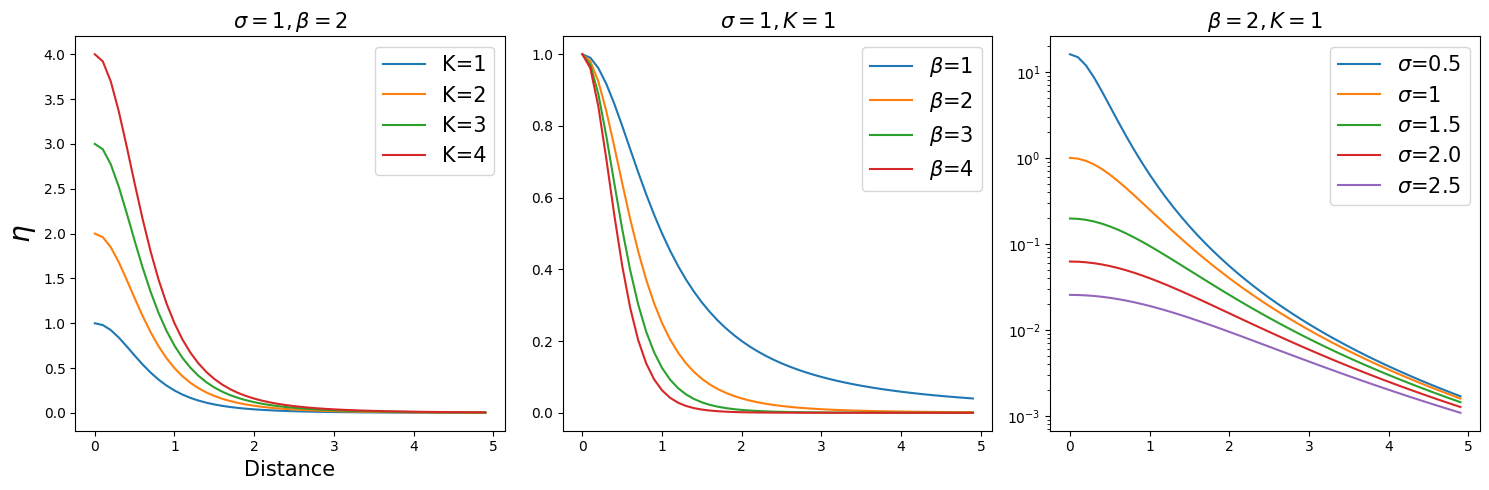

In [84]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

for K in np.arange(1,5):
    ax[0].plot(np.arange(0,5,0.1), eta(np.arange(0,5,0.1), K, 1, 2), label='K={}'.format(K))
ax[0].set_xlabel('Distance', fontsize=15)
ax[0].set_ylabel('$\\eta$', fontsize=20)
ax[0].set_title('$\\sigma=1, \\beta=2$', fontsize=15)
ax[0].legend(fontsize=15)

for b in np.arange(1,5):
    ax[1].plot(np.arange(0,5,0.1), eta(np.arange(0,5,0.1), 1, 1, b), label='$\\beta$={}'.format(b))
ax[1].set_title('$\\sigma=1, K=1$', fontsize=15)
ax[1].legend(fontsize=15)

for s in [0.5, 1, 1.5, 2.0, 2.5]:
    ax[2].plot(np.arange(0,5,0.1), eta(np.arange(0,5,0.1), 1, s, 2), label='$\\sigma$={}'.format(s))
ax[2].set_title('$\\beta=2, K=1$', fontsize=15)
ax[2].legend(fontsize=15)
ax[2].set_yscale('log')

fig.tight_layout()

In [2]:
class flock:
    def __init__(self, N, D, L, K, s, b):
        """
        Initialize flocking simulation with N particles in D dimensional periodic box of size L
        K, s, b tune the influence function
        """
        #geometry parameters
        self.N=N; self.D=D; self.L=L; self.dt=0.001
        #influence function parameters
        self.K=K; self.s=s; self.b=b
        
        #initialize positions and velocities randomly
        self.xs = (np.random.normal(size=(self.N, self.D))+0.5*np.asarray([self.L,self.L]))%self.L
        self.vs = np.random.normal(size=(self.N, self.D))
        self.OP = [self.cos_var()]
        
    def compute_adj(self):
        """
        compute adjacency matrix from the influence function
        """
        mags = np.sum(np.square(np.diagonal(np.subtract.outer(self.xs, self.xs), axis1=1, axis2=3)), axis=2)
        self.aij = self.K/np.power(self.s**2 + mags, self.b)
        
    def compute_vgrad(self):
        """
        compute time derivative of each agent velocity
        """
        self.compute_adj()
        self.dV_dt = -1.0*np.sum(self.aij.reshape(self.N,self.N,1)*np.diagonal(np.subtract.outer(self.vs, self.vs), 
                                                                          axis1=1, axis2=3), axis=1)        
    def var_step(self):
        """
        compute gradients and increment positions and velocities with first order time step
        """
        self.compute_vgrad()
        self.xs = (self.xs+self.dt*self.vs)%self.L
        self.vs += self.dt*self.dV_dt
        
    def cos_var(self):
        """
        compute order parameter
        """
        dp_mat = self.vs@self.vs.T
        mags = np.sqrt(np.sum(self.vs*self.vs, axis=1))
        cos_terms = dp_mat/np.multiply.outer(mags, mags)
        return np.var(cos_terms[np.triu_indices(self.N, k=1)])
    
    def simulate(self, Nstep=1500):
        """
        simulate dynamics for Nstep time steps and track order parameter over time
        """
        for i in np.arange(Nstep):
            self.var_step()
            self.OP.append(self.cos_var())

In [7]:
example = flock(250, 2, 1.0, 1.0, 1.0, 3)

In [8]:
example.simulate(N=1500)

An example flock shown below. Notice how $z$ plummets to 0 almost immediately and the flock is almost completely aligned.

Text(0, 0.5, '$z$')

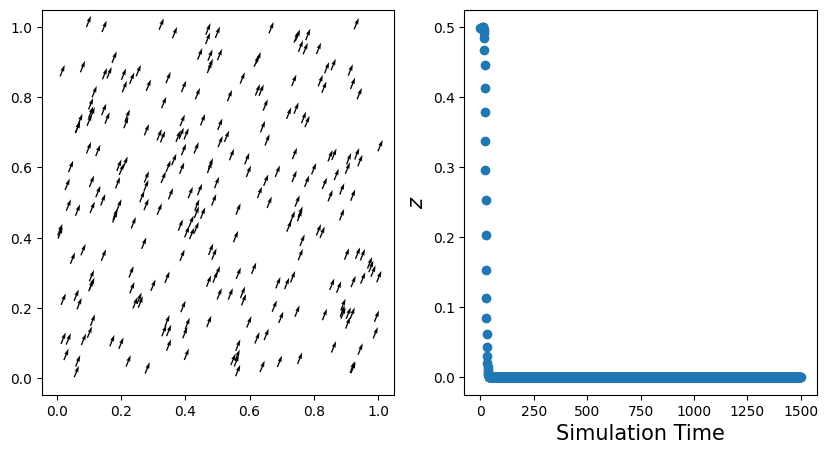

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

#ax.scatter(tst.xs[:,0], tst.xs[:,1])
ax[0].quiver(example.xs[:,0], example.xs[:,1], example.vs[:,0], example.vs[:,1])
ax[1].scatter(range(len(example.OP)), example.OP)
ax[1].set_xlabel('Simulation Time', fontsize=15)
ax[1].set_ylabel('$z$', fontsize=15)

In [40]:
beta = [1, 2, 3, 4, 5]
beta_tests = []
for b in beta:
    tmp = flock(250, 2, 1.0, 1.0, 1.0, b)
    tmp.simulate(N=100)
    beta_tests.append(tmp)

Text(0.5, 1.0, 'N=250, D=2, K=1, $\\sigma=1$')

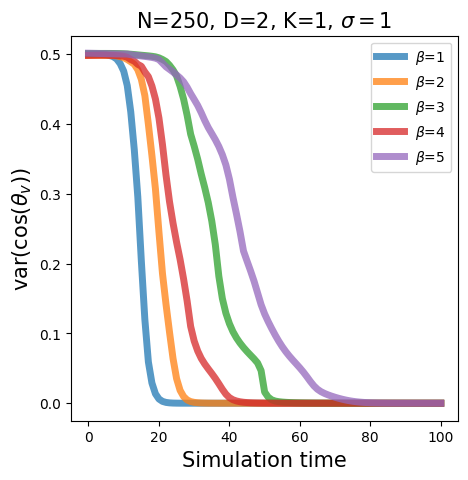

In [71]:
fig, ax = plt.subplots(figsize=(5,5))

for tmp in beta_tests:
    ax.plot(range(len(tmp.OP)), tmp.OP, lw=5, alpha=0.75, label='$\\beta$={}'.format(tmp.b))
ax.legend()
ax.set_ylabel("var($\\cos(\\theta_v))$", fontsize=15)
ax.set_xlabel("Simulation time", fontsize=15)

ax.set_title('N=250, D=2, K=1, $\\sigma=1$', fontsize=15)

In [61]:
Ks = [1, 1.5, 2, 2.5, 3]
K_tests = []
for k in Ks:
    tmp = flock(250, 2, 1.0, k, 1.0, 2)
    tmp.simulate(N=50)
    K_tests.append(tmp)

Text(0.5, 1.0, 'N=250, D=2, $\\sigma=1$, $\\beta=2$')

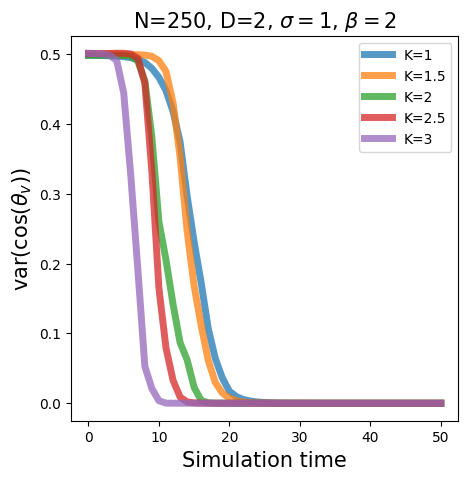

In [70]:
fig, ax = plt.subplots(figsize=(5,5))

for tmp in K_tests:
    ax.plot(range(len(tmp.OP)), tmp.OP, lw=5, alpha=0.75, label='K={}'.format(tmp.K))
ax.legend()
ax.set_ylabel("var($\\cos(\\theta_v))$", fontsize=15)
ax.set_xlabel("Simulation time", fontsize=15)

ax.set_title('N=250, D=2, $\\sigma=1$, $\\beta=2$', fontsize=15)

In [64]:
sigmas = [0.5, 1, 1.5, 2.0, 2.5]
sig_tests = []
for s in sigmas:
    tmp = flock(250, 2, 1.0, 1.0, s, 2)
    tmp.simulate(N=750)
    sig_tests.append(tmp)

Text(0.5, 1.0, 'N=250, D=2, K=1, $\\beta=1$')

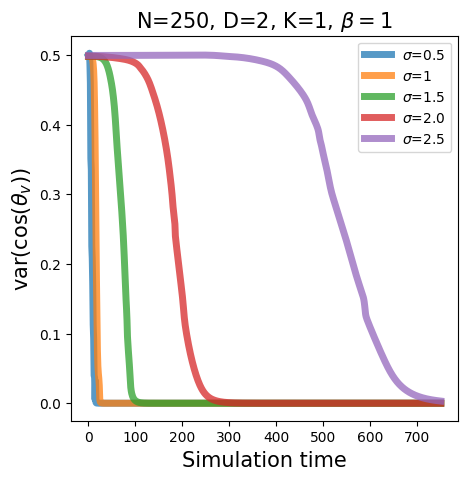

In [69]:
fig, ax = plt.subplots(figsize=(5,5))

for tmp in sig_tests:
    ax.plot(range(len(tmp.OP)), tmp.OP, lw=5, alpha=0.75, label='$\\sigma$={}'.format(tmp.s))
ax.legend()
ax.set_ylabel("var($\\cos(\\theta_v))$", fontsize=15)
ax.set_xlabel("Simulation time", fontsize=15)

ax.set_title('N=250, D=2, K=1, $\\beta=2$', fontsize=15)